In [687]:
# Bibliotecas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import torch
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report
from tensorflow.keras.utils import to_categorical
from torch import nn

In [688]:
# Carregando dados
inputData = pd.read_csv('./Datasets/mobile/train.csv')
data = inputData.drop('price_range', axis=1)
labels = inputData['price_range']

In [689]:
# Dividir para treinamento e validação
data = data.values
labels = labels.values
data_train, data_test, labels_train, labels_test = train_test_split(data, labels, test_size=0.2, random_state=123)
data_train, data_validation, labels_train, labels_validation =train_test_split(data_train, labels_train, test_size=0.2)

In [690]:
#One hot encoding
labels_train_onehot = to_categorical(labels_train)
labels_test_onehot = to_categorical(labels_test)
labels_validation_onehot = to_categorical(labels_validation)

In [691]:
data_train = torch.FloatTensor(data_train)
data_test = torch.FloatTensor(data_test)
labels_train = torch.FloatTensor(labels_train)
labels_test = torch.FloatTensor(labels_test)

labels_train_onehot = torch.FloatTensor(labels_train_onehot)
labels_test_onehot = torch.FloatTensor(labels_test_onehot)
labels_validation_onehot = torch.FloatTensor(labels_validation_onehot)

data_validation = torch.FloatTensor(data_validation)
labels_validation = torch.FloatTensor(labels_validation)


In [692]:
# Rede Neural
class MobilePriceClassifier(nn.Module) :
    def __init__(self, input_size = 20, hidden_size1 = 20, hidden_size2 = 40, hidden_size3 = 20, hidden_size4 = 10, output_size=4) :
        super().__init__()
        self.layer1 = nn.Linear(input_size, hidden_size1)
        self.layer2 = nn.Linear(hidden_size1, hidden_size2)
        self.layer3 = nn.Linear(hidden_size2, hidden_size3)
        self.layer4 = nn.Linear(hidden_size3, hidden_size4)
        self.layer5 = nn.Linear(hidden_size4, output_size)

    def forward(self, data) :
        data = F.relu(self.layer1(data))
        data = F.relu(self.layer2(data))
        data = F.relu(self.layer3(data))
        data = F.relu(self.layer4(data))
        data = self.layer5(data)
        return data

In [693]:
rna = MobilePriceClassifier()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(rna.parameters(), lr=0.01)

In [694]:
def train_network(model, optimizer, criterion, data_train, labels_train, data_test, labels_test, num_epochs, train_losses, test_losses) :
    for i in range(num_epochs) :
        optimizer.zero_grad()
        label_train = model.forward(data_train) # Pegando a previsão
        loss_train = criterion(label_train, labels_train)
        loss_train.backward()
        optimizer.step()
        
        label_test = model(data_test)
        loss_test = criterion(label_test, labels_test)
        
        train_losses.append(loss_train.detach().numpy())
        test_losses.append(loss_test.detach().numpy())

        if i%100 == 0 :
            print(f'Época {i}, Erro de Treinamento : {loss_train}, Erro de Validação : {loss_test}')

In [695]:
num_epochs = 1000
train_losses = []
test_losses = []

In [696]:
train_network(rna, optimizer, criterion, data_train, labels_train_onehot, data_validation, labels_validation_onehot, num_epochs, train_losses, test_losses)

Época 0, Erro de Treinamento : 9.118368148803711, Erro de Validação : 1.5280554294586182


Época 100, Erro de Treinamento : 0.6096462607383728, Erro de Validação : 0.6467950940132141
Época 200, Erro de Treinamento : 0.5147233605384827, Erro de Validação : 0.6350958943367004
Época 300, Erro de Treinamento : 0.45672255754470825, Erro de Validação : 0.5916107296943665
Época 400, Erro de Treinamento : 0.438021183013916, Erro de Validação : 0.5667750835418701
Época 500, Erro de Treinamento : 0.35204631090164185, Erro de Validação : 0.5244625806808472
Época 600, Erro de Treinamento : 0.3259001672267914, Erro de Validação : 0.542354941368103
Época 700, Erro de Treinamento : 0.38438743352890015, Erro de Validação : 0.6406605243682861
Época 800, Erro de Treinamento : 0.3041643798351288, Erro de Validação : 0.4898112714290619
Época 900, Erro de Treinamento : 0.24778464436531067, Erro de Validação : 0.4863186776638031


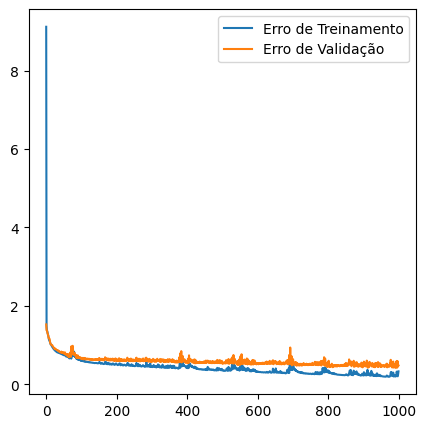

In [697]:
plt.figure(figsize=(5,5))
plt.plot(train_losses, label='Erro de Treinamento')
plt.plot(test_losses, label='Erro de Validação')
plt.legend()
plt.show()

In [698]:
class_predict_onehot = rna(data_test)
class_predict = class_predict_onehot.argmax(axis=1)
confusion_matriz = confusion_matrix(labels_test, class_predict, labels=range(3))
print("----- Matriz de Confusão - Dados de Teste -----")
confusion_matriz

----- Matriz de Confusão - Dados de Teste -----


array([[84,  3,  0],
       [10, 81,  9],
       [ 0, 13, 97]], dtype=int64)

In [699]:
precision = precision_score(labels_test, class_predict, average='weighted', zero_division=1)
recall_score = recall_score(labels_test, class_predict, average='weighted', zero_division=1)
f1_score = f1_score(labels_test, class_predict, average='weighted', zero_division=1)
accuracy_score = accuracy_score(labels_test, class_predict)

print("-----Métricas no Geral------")
print("Precisão : ", precision)
print("Revocação : ",  recall_score)
print("F1 - Score: ", f1_score)
print("Acurácia : ", accuracy_score)


-----Métricas no Geral------
Precisão :  0.8747545609735163
Revocação :  0.875
F1 - Score:  0.8744674903158343
Acurácia :  0.875


In [700]:
precision, recall_score, f1_score, support = precision_recall_fscore_support(labels_test, class_predict, zero_division=1)

print("-------Métricas para cada classe-------")
confusion_matriz = confusion_matriz.astype('float') / confusion_matriz.sum(axis=1)[:, np.newaxis]
accuracy_score = confusion_matriz.diagonal()


print("Acurácia : ", accuracy_score)

print(classification_report(labels_test, class_predict, zero_division=1))

-------Métricas para cada classe-------
Acurácia :  [0.96551724 0.81       0.88181818]
              precision    recall  f1-score   support

         0.0       0.89      0.97      0.93        87
         1.0       0.84      0.81      0.82       100
         2.0       0.84      0.84      0.84       116
         3.0       0.94      0.91      0.92        97

    accuracy                           0.88       400
   macro avg       0.88      0.88      0.88       400
weighted avg       0.87      0.88      0.87       400

